<a href="https://colab.research.google.com/github/Nekokan1500/Machine-Learning/blob/main/Deep_Learning/Example_Using_Keras.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.datasets import mnist

In [2]:
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

11501568/11490434 [==============================] - 0s 0us/step


In [3]:
print(train_images.shape)
print(test_images.shape)

(60000, 28, 28)
(10000, 28, 28)


In [4]:
print(len(train_labels))
print(len(test_labels))

60000
10000


In [5]:
model = keras.Sequential([layers.Dense(512, activation="relu"), 
                          layers.Dense(10, activation="softmax")])
model.compile(optimizer="rmsprop", 
              loss="sparse_categorical_crossentropy",
              metrics=["accuracy"])

train_images = train_images.reshape((60000, 28*28))
train_images = train_images.astype("float32")/255
test_images = test_images.reshape((10000, 28*28))
test_images = test_images.astype("float32")/255

In [6]:
model.fit(train_images, train_labels, epochs=5, batch_size=128)

Epoch 1/5
469/469 [==============================] - 6s 10ms/step - loss: 0.2591 - accuracy: 0.9232
Epoch 2/5
469/469 [==============================] - 5s 10ms/step - loss: 0.1041 - accuracy: 0.9689
Epoch 3/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0683 - accuracy: 0.9793
Epoch 4/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0498 - accuracy: 0.9851
Epoch 5/5
469/469 [==============================] - 5s 10ms/step - loss: 0.0381 - accuracy: 0.9884


In [7]:
def display_img(img, target, ax):
  img = img.reshape((28,28))
  ax.imshow(img, cmap='gray')
  ax.set_title(f'Digit: {str(target)}')
  ax.grid(False)

[7.1687829e-08 3.7164154e-11 7.4916185e-05 1.3959939e-04 6.7845702e-13
 1.8369743e-08 8.0372830e-15 9.9977499e-01 7.3273907e-07 9.7309294e-06]
Predicted label: 7
Expected label: 7


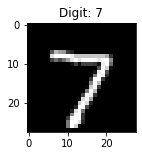

In [8]:
test_digits = test_images[0:10]
predictions = model.predict(test_digits)
print(predictions[0])
print(f"Predicted label: {predictions[0].argmax()}")
print(f"Expected label: {test_labels[0]}")

fig, ax = plt.subplots(1,1,figsize=(2,2))
display_img(test_digits[0], test_labels[0], ax)

In [9]:
test_loss, test_acc = model.evaluate(test_images, test_labels)
print(f"Test accuracy: {test_acc:.3f}")

313/313 [==============================] - 1s 3ms/step - loss: 0.0728 - accuracy: 0.9785
Test accuracy: 0.979


In [10]:
# Reimplementing the above process from sratch
class NaiveDense:
  def __init__(self, input_size, output_size, activation):
    self.activation = activation
    w_shape = (input_size, output_size)
    w_initial_value = tf.random.uniform(w_shape, minval=0, maxval=1e-1)
    self.W = tf.Variable(w_initial_value)
    b_shape = (output_size,)
    b_initial_value = tf.zeros(b_shape)
    self.b = tf.Variable(b_initial_value)
  
  def __call__(self, inputs):
    return self.activation(tf.matmul(inputs, self.W) + self.b)

  @property
  def weights(self):
    return [self.W, self.b]

class NaiveSequential:
  def __init__(self, layers):
    self.layers = layers

  def __call__(self, inputs):
    x = inputs
    for layer in self.layers:
      x = layer(x)
    return x

  @property
  def weights(self):
    weights = []
    for layer in self.layers:
      weights += layer.weights
    return weights

In [11]:
# Using the naive implementation of neural network
model = NaiveSequential([
     NaiveDense(input_size=28*28, output_size=512, activation=tf.nn.relu),
     NaiveDense(input_size=512, output_size=10, activation=tf.nn.softmax)
])
assert len(model.weights) == 4

In [12]:
# A batch generator
import math

class BatchGenerator:
  def __init__(self, images, labels, batch_size=128):
    assert len(images) == len(labels)
    self.index = 0
    self.images = images
    self.labels = labels
    self.batch_size = batch_size
    self.num_batches = math.ceil((len(images)/batch_size))

  def next(self):
    images = self.images[self.index : self.index + self.batch_size]
    labels = self.labels[self.index : self.index + self.batch_size]
    self.index += self.batch_size
    return images, labels

In [28]:
# Naive implementation of the training process
def one_training_step(model, images_batch, labels_batch):
  with tf.GradientTape() as tape:
    predictions = model(images_batch)
    per_sample_losses = tf.keras.losses.sparse_categorical_crossentropy(
        labels_batch, predictions)
    average_loss = tf.reduce_mean(per_sample_losses)
  gradients = tape.gradient(average_loss, model.weights)
  update_weights(gradients, model.weights)
  return average_loss

def update_weights(gradients, weights, learning_rate=1e-3):
  for g, w in zip(gradients, weights):
    w.assign_sub(g*learning_rate)

In [23]:
# The full training loop
def fit(model, images, labels, epochs, batch_size=128):
  for epoch_counter in range(epochs):
    print(f"Epoch {epoch_counter}")
    batch_generator = BatchGenerator(images, labels)
    for batch_counter in range(batch_generator.num_batches):
      images_batch, labels_batch = batch_generator.next()
      loss = one_training_step(model, images_batch, labels_batch)
      if batch_counter % 100 == 0:
        print(f"loss at batch {batch_counter}: {loss:.2f}")

In [29]:
# Running the training
fit(model, train_images, train_labels, epochs=10, batch_size=128)
predictions = model(test_images)
predictions = predictions.numpy()
predicted_labels = np.argmax(predictions, axis=1)
matches = predicted_labels == test_labels
print(f"accuracy: {matches.mean():.2f}")

Epoch 0
loss at batch 0: 0.60
loss at batch 100: 0.60
loss at batch 200: 0.51
loss at batch 300: 0.58
loss at batch 400: 0.66
Epoch 1
loss at batch 0: 0.55
loss at batch 100: 0.57
loss at batch 200: 0.49
loss at batch 300: 0.56
loss at batch 400: 0.64
Epoch 2
loss at batch 0: 0.53
loss at batch 100: 0.54
loss at batch 200: 0.47
loss at batch 300: 0.54
loss at batch 400: 0.62
Epoch 3
loss at batch 0: 0.51
loss at batch 100: 0.52
loss at batch 200: 0.45
loss at batch 300: 0.52
loss at batch 400: 0.61
Epoch 4
loss at batch 0: 0.49
loss at batch 100: 0.50
loss at batch 200: 0.43
loss at batch 300: 0.51
loss at batch 400: 0.60
Epoch 5
loss at batch 0: 0.48
loss at batch 100: 0.49
loss at batch 200: 0.42
loss at batch 300: 0.49
loss at batch 400: 0.58
Epoch 6
loss at batch 0: 0.46
loss at batch 100: 0.47
loss at batch 200: 0.41
loss at batch 300: 0.48
loss at batch 400: 0.57
Epoch 7
loss at batch 0: 0.45
loss at batch 100: 0.46
loss at batch 200: 0.39
loss at batch 300: 0.47
loss at batch 40